# 3_scann_grid — ScaNN: grid search по гиперпараметрам и анализ trade-off качество/время

Этот ноутбук повторяет структуру `2_lorann.ipynb`, но для **ScaNN** и с **сеткой гиперпараметров**.

Предполагается, что вы уже запустили `0_data.ipynb` и в `./artifacts/data` лежат артефакты:
- `glove{d}d_base_...__ds<DATASET_ID>.npz`
- `glove{d}d_queries_...__ds<DATASET_ID>.npz`
- `glove{d}d_gt_test_...__ds<DATASET_ID>.npz`

Главные требования воспроизводимости:
- один и тот же `dataset_id` для base/queries/gt;
- один и тот же набор тестовых запросов `q_idx_test` для всех методов;
- строгое исключение self-match (т.к. queries взяты из базы).


In [7]:
import json
import re
import time
from dataclasses import asdict
from itertools import product
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from IPython.display import display

# ----------------------------
# Поиск корня репозитория
# ----------------------------
p = Path.cwd().resolve()
REPO_ROOT = None
for _ in range(10):
    if (p / "artifacts" / "data").exists() and (p / "methods").exists():
        REPO_ROOT = p
        break
    p = p.parent

if REPO_ROOT is None:
    raise FileNotFoundError(
        "Не удалось найти корень репозитория: ожидаю папки artifacts/data и methods в родителях."
    )

ARTIFACTS_DATA = (REPO_ROOT / "artifacts" / "data").resolve()
ARTIFACTS_RUNS = (REPO_ROOT / "artifacts" / "runs").resolve()

print("REPO_ROOT:", REPO_ROOT)
print("ARTIFACTS_DATA:", ARTIFACTS_DATA)
print("ARTIFACTS_RUNS:", ARTIFACTS_RUNS)

# ----------------------------
# Импорт ScaNN (как в 2_lorann.ipynb: импорт из methods/ + reload)
# ----------------------------
import sys
import importlib

METHODS_DIR = (REPO_ROOT / "methods").resolve()
sys.path.insert(0, str(METHODS_DIR))

import scann as _scann_mod  # noqa: E402
_scann_mod = importlib.reload(_scann_mod)

ScannConfig = _scann_mod.ScannConfig
ScannIndex = _scann_mod.ScannIndex

# ----------------------------
# Утилиты
# ----------------------------
def parse_dataset_id(path: Path) -> str:
    m = re.search(r"__ds([A-Za-z0-9]+)\.npz$", path.name)
    if not m:
        raise ValueError(f"Не смог распарсить dataset_id из имени файла: {path.name}")
    return m.group(1)

def pick_triplet_for_dim(dim: int, dataset_id: Optional[str] = None) -> Tuple[Path, Path, Path, str]:
    """Найти (base, queries, gt_test) для заданной размерности и dataset_id.

    Если dataset_id=None, берём самый свежий base-файл по mtime и используем его dataset_id.
    """
    base_candidates = sorted(ARTIFACTS_DATA.glob(f"glove{dim}d_base_*__ds*.npz"), key=lambda p: p.stat().st_mtime, reverse=True)
    if not base_candidates:
        raise FileNotFoundError(f"Не нашёл base-артефакты для dim={dim} в {ARTIFACTS_DATA}")

    if dataset_id is None:
        base_path = base_candidates[0]
        ds = parse_dataset_id(base_path)
    else:
        ds = str(dataset_id)
        base_path = None
        for pth in base_candidates:
            if parse_dataset_id(pth) == ds:
                base_path = pth
                break
        if base_path is None:
            raise FileNotFoundError(f"Не нашёл base для dim={dim} и dataset_id={ds}")

    queries = list(ARTIFACTS_DATA.glob(f"glove{dim}d_queries_*__ds{ds}.npz"))
    gt = list(ARTIFACTS_DATA.glob(f"glove{dim}d_gt_test_*__ds{ds}.npz"))
    if len(queries) != 1 or len(gt) != 1:
        raise FileNotFoundError(
            f"Ожидаю ровно по одному файлу queries и gt для dim={dim}, ds={ds}, "
            f"но нашёл queries={len(queries)}, gt={len(gt)}"
        )
    return base_path, queries[0], gt[0], ds

def recall_at_k(pred_ids: np.ndarray, gt_ids: np.ndarray, k: int) -> float:
    """Recall@k как в 2_lorann.ipynb: доля совпавших элементов в топ-k."""
    k = int(k)
    k = min(k, pred_ids.shape[1], gt_ids.shape[1])
    hits = 0
    denom = pred_ids.shape[0] * k
    for i in range(pred_ids.shape[0]):
        hits += len(set(pred_ids[i, :k].tolist()) & set(gt_ids[i, :k].tolist()))
    return float(hits) / float(denom) if denom > 0 else 0.0

def ms_per_query(seconds: float, nq: int) -> float:
    return 1000.0 * float(seconds) / float(max(1, nq))

def load_artifacts(dim: int, dataset_id: Optional[str] = None) -> Dict[str, np.ndarray]:
    base_path, q_path, gt_path, ds = pick_triplet_for_dim(dim, dataset_id=dataset_id)
    base = np.load(base_path)
    queries = np.load(q_path)
    gt = np.load(gt_path)

    # строгие проверки целостности
    ds_base = str(base["dataset_id"])
    ds_q = str(queries["dataset_id"])
    ds_gt = str(gt["dataset_id"])
    if not (ds_base == ds_q == ds_gt == ds):
        raise ValueError(f"dataset_id mismatch: base={ds_base}, queries={ds_q}, gt={ds_gt}, expected={ds}")

    return {
        "dataset_id": ds,
        "base_path": base_path,
        "queries_path": q_path,
        "gt_path": gt_path,
        "Xn": base["Xn"].astype(np.float32, copy=False),
        "Qn_test": queries["Qn_test"].astype(np.float32, copy=False),
        "q_idx_test": queries["q_idx_test"].astype(np.int32, copy=False),
        "gt_ids": gt["gt_ids"].astype(np.int32, copy=False),
        "gt_scores": gt["gt_scores"].astype(np.float32, copy=False),
    }

print("Импорт и утилиты готовы.")


REPO_ROOT: /home/ammo/Documents/AI-Masters/Вычислительная линейная алгебра/2025_2026/HW/Final_project/ann-nla-project
ARTIFACTS_DATA: /home/ammo/Documents/AI-Masters/Вычислительная линейная алгебра/2025_2026/HW/Final_project/ann-nla-project/artifacts/data
ARTIFACTS_RUNS: /home/ammo/Documents/AI-Masters/Вычислительная линейная алгебра/2025_2026/HW/Final_project/ann-nla-project/artifacts/runs
Импорт и утилиты готовы.


## 1) Grid search: Fit + Search + Save runs

Ниже задаётся **сетка гиперпараметров** ScaNN и выполняются прогоны по `d ∈ {50,100,200,300}`.

Рекомендации:
- начните с `GRID_MODE="small"` (10–30 прогонов на размерность);
- далее можно расширять сетку и/или поднимать `candidate_count`, `reorder_k`, `nprobe` для роста recall.


In [8]:
# ----------------------------
# Настройки эксперимента
# ----------------------------
DIMS = [50, 100, 200, 300]
RUN_DIMS = DIMS  # можно заменить на [300], если нужно быстрее

TOP_K = 10
EVAL_KS = [1, 10]

# Если в artifacts/data лежит несколько dataset_id, можно зафиксировать нужный:
DATASET_ID: Optional[str] = None  # например: "abc123"

# Повторный запуск: пропускать уже существующие run-файлы
FORCE_RERUN = False

# Папка для run-файлов
RUNS_DIR = (ARTIFACTS_RUNS / "scann").resolve()
RUNS_DIR.mkdir(parents=True, exist_ok=True)

# ----------------------------
# Сетка гиперпараметров
# ----------------------------
GRID_MODE = "small"  # "small" или "full"

# Основные параметры ScaNN, влияющие на качество/скорость:
# 1) coarse routing: nlist, nprobe
# 2) PQ scoring: n_codewords (Ks), n_subspaces (M), gamma
# 3) rerank: candidate_count, reorder_k
if GRID_MODE == "full":
    GRID_NLIST = [256, 512, 1024]
    GRID_NPROBE = [8, 16]
    GRID_KS = [64, 128]
    GRID_M = [10]           # удобно для GloVe 50/100/200/300
    GRID_GAMMA = [1.0, 1.1] # 1.0 = обычный PQ, 1.1 = лёгкая анизотропия
    GRID_CAND = [2000, 8000]
    GRID_RK = [200, 2000]
else:
    GRID_NLIST = [256, 512, 1024, 2048]
    GRID_NPROBE = [8, 16, 32]
    GRID_KS = [64, 128, 256]
    GRID_M = [10, 16, 20]
    GRID_GAMMA = [1.0, 1.1, 1.25]
    GRID_CAND = [2000, 8000, 20000]
    GRID_RK = [200, 2000, 10000]

# Параметры обучения (обычно не перебираем в сетке, чтобы не раздувать число прогонов)
COARSE_TRAIN_SIZE = 50_000
COARSE_ITERS = 20
PQ_TRAIN_SIZE = 20_000
PQ_ITERS = 10
RANDOM_STATE = 0

grid: List[ScannConfig] = []
for nlist, nprobe, ks, M, g, cand, rk in product(
    GRID_NLIST, GRID_NPROBE, GRID_KS, GRID_M, GRID_GAMMA, GRID_CAND, GRID_RK
):
    # небольшая эвристика: rk не должен превышать cand
    if rk > cand:
        continue
    grid.append(
        ScannConfig(
            nlist=int(nlist),
            nprobe=int(nprobe),
            n_subspaces=int(M),
            n_codewords=int(ks),
            gamma=float(g),
            coarse_train_size=int(COARSE_TRAIN_SIZE),
            coarse_n_iters=int(COARSE_ITERS),
            pq_train_size=int(PQ_TRAIN_SIZE),
            pq_n_iters=int(PQ_ITERS),
            candidate_count=int(cand),
            reorder_k=int(rk),
            random_state=int(RANDOM_STATE),
        )
    )

print(f"GRID_MODE={GRID_MODE} -> число конфигураций: {len(grid)}")

MAX_CONFIGS_PER_DIM: Optional[int] = 24  # None -> использовать всю сетку (может быть очень долго)
if MAX_CONFIGS_PER_DIM is not None and len(grid) > MAX_CONFIGS_PER_DIM:
    rng = np.random.RandomState(0)
    idx = rng.choice(len(grid), size=int(MAX_CONFIGS_PER_DIM), replace=False)
    grid = [grid[i] for i in idx]
    print(f"Сетка подсэмплирована до {len(grid)} конфигураций на размерность (MAX_CONFIGS_PER_DIM={MAX_CONFIGS_PER_DIM}).")


# ----------------------------
# Запуски
# ----------------------------
for dim in RUN_DIMS:
    art = load_artifacts(dim, dataset_id=DATASET_ID)
    ds = art["dataset_id"]
    Xn = art["Xn"]
    Q_test = art["Qn_test"]
    q_idx_test = art["q_idx_test"]
    gt_ids = art["gt_ids"]

    # папка для данного датасета
    ds_dir = (RUNS_DIR / f"ds{ds}").resolve()
    ds_dir.mkdir(parents=True, exist_ok=True)

    print("\n" + "=" * 80)
    print(f"dim={dim} | DATASET_ID={ds} | Xn={Xn.shape} | Q_test={Q_test.shape} | GT={gt_ids.shape}")

    for cfg in tqdm(grid, desc=f"Grid dim={dim}", leave=False):
        run_name = (
            f"scann__ds{ds}__d{dim}__k{TOP_K}"
            f"__nlist{cfg.nlist}__nprobe{cfg.nprobe}"
            f"__M{cfg.n_subspaces}__Ks{cfg.n_codewords}__g{cfg.gamma}"
            f"__cand{cfg.candidate_count}__rk{cfg.reorder_k}"
            f"__pqtr{cfg.pq_train_size}__pqit{cfg.pq_n_iters}"
            f"__ctr{cfg.coarse_train_size}__cit{cfg.coarse_n_iters}"
            f"__seed{cfg.random_state}.npz"
        )
        run_path = ds_dir / run_name
        if run_path.exists() and not FORCE_RERUN:
            continue

        # Fit
        index = ScannIndex(cfg)
        t0 = time.perf_counter()
        index.fit(Xn, assume_normalized=True)
        t_fit = time.perf_counter() - t0

        # Search
        t0 = time.perf_counter()
        pred_ids, pred_scores = index.search_batch(Q_test, top_k=TOP_K, exclude_ids=q_idx_test)
        t_search = time.perf_counter() - t0
        t_ms = ms_per_query(t_search, Q_test.shape[0])

        # Eval (быстро, как sanity check)
        r10 = recall_at_k(pred_ids, gt_ids, 10)

        run_meta = {
            "method": "scann",
            "dataset_id": ds,
            "dim": int(dim),
            "pred_k": int(TOP_K),
            "eval_ks": [int(k) for k in EVAL_KS],
            **asdict(cfg),
            "fit_seconds": float(t_fit),
            "search_seconds": float(t_search),
            "ms_per_query": float(t_ms),
            "recall_at_10": float(r10),
            "base_file": art["base_path"].name,
            "queries_file": art["queries_path"].name,
            "gt_file": art["gt_path"].name,
        }

        np.savez_compressed(
            run_path,
            dataset_id=np.array(ds, dtype=np.str_),
            pred_ids=pred_ids.astype(np.int32, copy=False),
            pred_scores=pred_scores.astype(np.float32, copy=False),
            meta=np.array(json.dumps(run_meta, ensure_ascii=False), dtype=np.str_),
        )

    print(f"Done dim={dim}. Runs in: {ds_dir}")


GRID_MODE=small -> число конфигураций: 2268
Сетка подсэмплирована до 24 конфигураций на размерность (MAX_CONFIGS_PER_DIM=24).

dim=50 | DATASET_ID=989456bc6cc2e6ed | Xn=(400000, 50) | Q_test=(20000, 50) | GT=(20000, 50)


Grid dim=50:   0%|          | 0/24 [00:00<?, ?it/s]

Done dim=50. Runs in: /home/ammo/Documents/AI-Masters/Вычислительная линейная алгебра/2025_2026/HW/Final_project/ann-nla-project/artifacts/runs/scann/ds989456bc6cc2e6ed

dim=100 | DATASET_ID=989456bc6cc2e6ed | Xn=(400000, 100) | Q_test=(20000, 100) | GT=(20000, 50)


Grid dim=100:   0%|          | 0/24 [00:00<?, ?it/s]

Done dim=100. Runs in: /home/ammo/Documents/AI-Masters/Вычислительная линейная алгебра/2025_2026/HW/Final_project/ann-nla-project/artifacts/runs/scann/ds989456bc6cc2e6ed

dim=200 | DATASET_ID=989456bc6cc2e6ed | Xn=(400000, 200) | Q_test=(20000, 200) | GT=(20000, 50)


Grid dim=200:   0%|          | 0/24 [00:00<?, ?it/s]

Done dim=200. Runs in: /home/ammo/Documents/AI-Masters/Вычислительная линейная алгебра/2025_2026/HW/Final_project/ann-nla-project/artifacts/runs/scann/ds989456bc6cc2e6ed

dim=300 | DATASET_ID=989456bc6cc2e6ed | Xn=(400000, 300) | Q_test=(20000, 300) | GT=(20000, 50)


Grid dim=300:   0%|          | 0/24 [00:00<?, ?it/s]

Done dim=300. Runs in: /home/ammo/Documents/AI-Masters/Вычислительная линейная алгебра/2025_2026/HW/Final_project/ann-nla-project/artifacts/runs/scann/ds989456bc6cc2e6ed


## 2) 4_eval_runs — Агрегация runs и графики

Секция ниже:
- собирает все `artifacts/runs/scann/ds<DATASET_ID>/*.npz`;
- пересчитывает Recall@K по `gt_test`;
- строит:
  - лучший Recall@10 по каждой размерности (bar);
  - Recall@10 по всем запускам (scatter);
  - **новые графики trade-off качество/время**:
    - Recall@10 vs fit_seconds
    - Recall@10 vs search_seconds
    - Recall@10 vs ms_per_query


Found run files: 96


,method,dataset_id,dim,nlist,nprobe,n_subspaces,n_codewords,gamma,candidate_count,reorder_k,...,recall_at_1,recall_at_10,run_file,pred_k,eval_ks,random_state,base_file,queries_file,gt_file,run_path
0,scann,989456bc6cc2e6ed,100,1024,16,16,256,1.00,20000,200,...,0.87485,0.804625,scann__ds989456bc6cc2e6ed__d100__k10__nlist102...,10,"[1, 10]",0,glove100d_base_N400000__ds989456bc6cc2e6ed.npz,glove100d_queries_N400000_nq100000_test20000_s...,glove100d_gt_test_N400000_nq20000_k50_seed42__...,/home/ammo/Documents/AI-Masters/Вычислительная...
1,scann,989456bc6cc2e6ed,100,1024,16,20,256,1.00,20000,2000,...,0.90290,0.881460,scann__ds989456bc6cc2e6ed__d100__k10__nlist102...,10,"[1, 10]",0,glove100d_base_N400000__ds989456bc6cc2e6ed.npz,glove100d_queries_N400000_nq100000_test20000_s...,glove100d_gt_test_N400000_nq20000_k50_seed42__...,/home/ammo/Documents/AI-Masters/Вычислительная...
2,scann,989456bc6cc2e6ed,100,1024,16,20,256,1.00,20000,200,...,0.89380,0.846670,scann__ds989456bc6cc2e6ed__d100__k10__nlist102...,10,"[1, 10]",0,glove100d_base_N400000__ds989456bc6cc2e6ed.npz,glove100d_queries_N400000_nq100000_test20000_s...,glove100d_gt_test_N400000_nq20000_k50_seed42__...,/home/ammo/Documents/AI-Masters/Вычислительная...
3,scann,989456bc6cc2e6ed,100,1024,32,10,64,1.00,20000,10000,...,0.92115,0.903120,scann__ds989456bc6cc2e6ed__d100__k10__nlist102...,10,"[1, 10]",0,glove100d_base_N400000__ds989456bc6cc2e6ed.npz,glove100d_queries_N400000_nq100000_test20000_s...,glove100d_gt_test_N400000_nq20000_k50_seed42__...,/home/ammo/Documents/AI-Masters/Вычислительная...
4,scann,989456bc6cc2e6ed,100,1024,8,10,128,1.00,2000,200,...,0.53090,0.466520,scann__ds989456bc6cc2e6ed__d100__k10__nlist102...,10,"[1, 10]",0,glove100d_base_N400000__ds989456bc6cc2e6ed.npz,glove100d_queries_N400000_nq100000_test20000_s...,glove100d_gt_test_N400000_nq20000_k50_seed42__...,/home/ammo/Documents/AI-Masters/Вычислительная...
5,scann,989456bc6cc2e6ed,100,1024,8,20,256,1.10,8000,200,...,0.78465,0.739200,scann__ds989456bc6cc2e6ed__d100__k10__nlist102...,10,"[1, 10]",0,glove100d_base_N400000__ds989456bc6cc2e6ed.npz,glove100d_queries_N400000_nq100000_test20000_s...,glove100d_gt_test_N400000_nq20000_k50_seed42__...,/home/ammo/Documents/AI-Masters/Вычислительная...
6,scann,989456bc6cc2e6ed,100,2048,16,16,128,1.25,8000,2000,...,0.82085,0.784820,scann__ds989456bc6cc2e6ed__d100__k10__nlist204...,10,"[1, 10]",0,glove100d_base_N400000__ds989456bc6cc2e6ed.npz,glove100d_queries_N400000_nq100000_test20000_s...,glove100d_gt_test_N400000_nq20000_k50_seed42__...,/home/ammo/Documents/AI-Masters/Вычислительная...
7,scann,989456bc6cc2e6ed,100,2048,16,20,128,1.00,20000,10000,...,0.89600,0.868995,scann__ds989456bc6cc2e6ed__d100__k10__nlist204...,10,"[1, 10]",0,glove100d_base_N400000__ds989456bc6cc2e6ed.npz,glove100d_queries_N400000_nq100000_test20000_s...,glove100d_gt_test_N400000_nq20000_k50_seed42__...,/home/ammo/Documents/AI-Masters/Вычислительная...
8,scann,989456bc6cc2e6ed,100,2048,16,20,64,1.00,2000,2000,...,0.60265,0.556125,scann__ds989456bc6cc2e6ed__d100__k10__nlist204...,10,"[1, 10]",0,glove100d_base_N400000__ds989456bc6cc2e6ed.npz,glove100d_queries_N400000_nq100000_test20000_s...,glove100d_gt_test_N400000_nq20000_k50_seed42__...,/home/ammo/Documents/AI-Masters/Вычислительная...
9,scann,989456bc6cc2e6ed,100,2048,32,20,256,1.10,8000,200,...,0.83200,0.786495,scann__ds989456bc6cc2e6ed__d100__k10__nlist204...,10,"[1, 10]",0,glove100d_base_N400000__ds989456bc6cc2e6ed.npz,glove100d_queries_N400000_nq100000_test20000_s...,glove100d_gt_test_N400000_nq20000_k50_seed42__...,/home/ammo/Documents/AI-Masters/Вычислительная...


Saved: /home/ammo/Documents/AI-Masters/Вычислительная линейная алгебра/2025_2026/HW/Final_project/ann-nla-project/artifacts/runs/scann/scann_eval_summary.csv


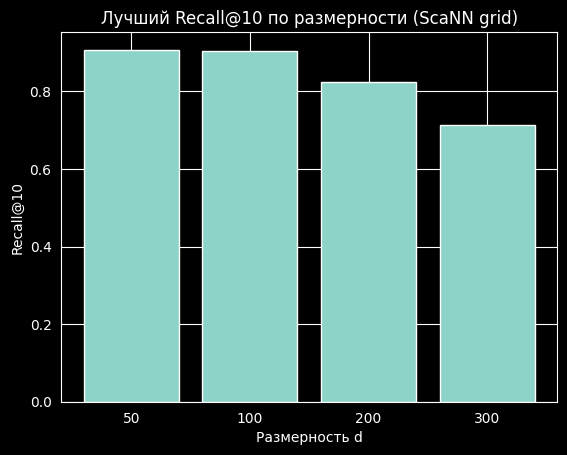

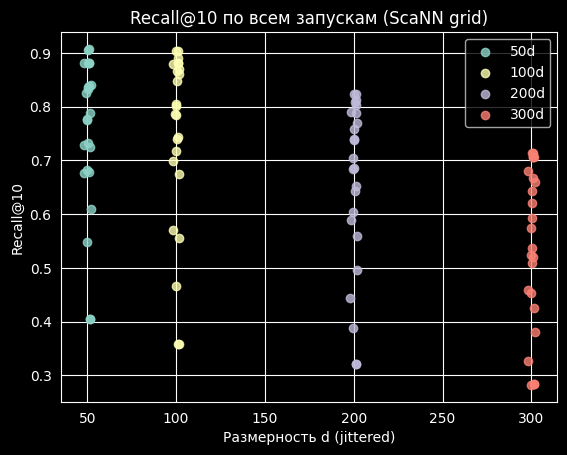

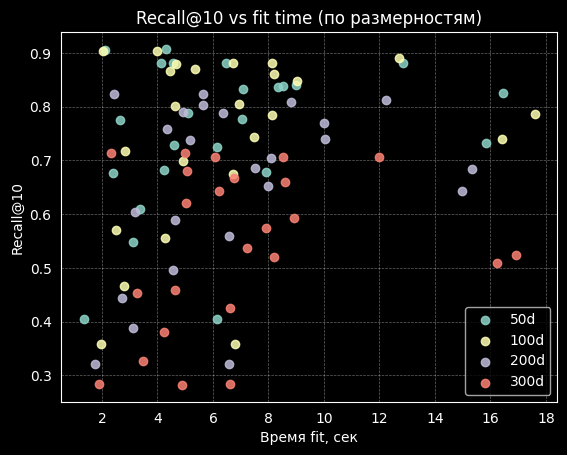

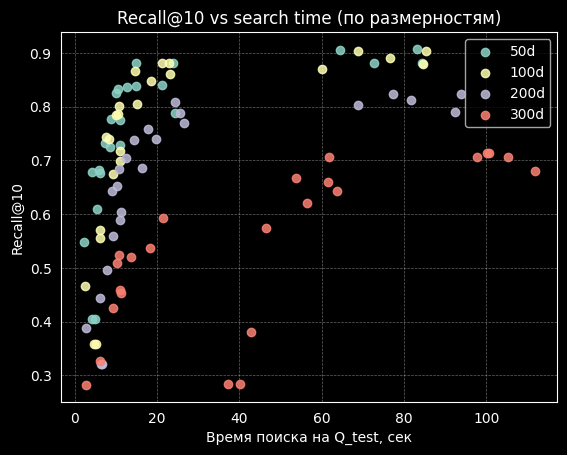

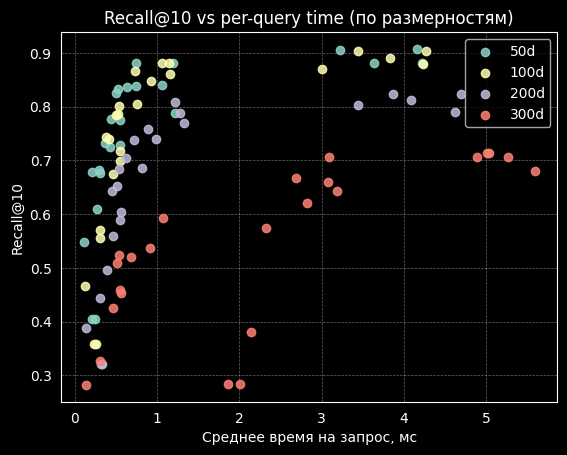

,dim,recall_at_10,fit_seconds,search_seconds,ms_per_query,nlist,nprobe,n_subspaces,n_codewords,gamma,candidate_count,reorder_k
0,50,0.907245,4.323181,83.149523,4.157476,512,32,20,64,1.1,20000,10000
1,100,0.903295,3.984656,85.351304,4.267565,512,32,20,64,1.1,20000,10000
2,200,0.824165,2.435541,77.347045,3.867352,1024,32,10,64,1.0,20000,10000
3,300,0.713705,2.340769,100.228318,5.011416,1024,32,10,64,1.0,20000,10000


In [9]:
# ----------------------------
# Сбор run-файлов
# ----------------------------
RUNS_DIR = (ARTIFACTS_RUNS / "scann").resolve()
if not RUNS_DIR.exists():
    raise FileNotFoundError(f"Не нашёл папку runs: {RUNS_DIR}")

run_files = sorted(RUNS_DIR.glob("ds*/scann__*.npz"))
print("Found run files:", len(run_files))
if len(run_files) == 0:
    raise RuntimeError("Нет ни одного run-файла. Сначала выполните секцию Grid search.")

# ----------------------------
# Кэш для GT по (dim, dataset_id)
# ----------------------------
_gt_cache: Dict[Tuple[int, str], np.ndarray] = {}

def load_gt_ids(dim: int, dataset_id: str) -> np.ndarray:
    key = (int(dim), str(dataset_id))
    if key in _gt_cache:
        return _gt_cache[key]
    _, _, gt_path, ds = pick_triplet_for_dim(dim, dataset_id=dataset_id)
    gt = np.load(gt_path)
    if str(gt["dataset_id"]) != ds:
        raise ValueError(f"GT dataset_id mismatch: {gt_path.name}")
    _gt_cache[key] = gt["gt_ids"].astype(np.int32, copy=False)
    return _gt_cache[key]

rows: List[Dict] = []
for rf in run_files:
    z = np.load(rf)
    ds = str(z["dataset_id"])
    meta = json.loads(str(z["meta"]))
    dim = int(meta["dim"])
    pred_ids = z["pred_ids"].astype(np.int32, copy=False)

    gt_ids = load_gt_ids(dim, ds)

    # пересчитываем recall, чтобы не зависеть от того, что сохранили в meta
    r1 = recall_at_k(pred_ids, gt_ids, 1)
    r10 = recall_at_k(pred_ids, gt_ids, 10)

    row = dict(meta)
    row["run_file"] = rf.name
    row["run_path"] = str(rf)
    row["recall_at_1"] = float(r1)
    row["recall_at_10"] = float(r10)
    rows.append(row)

df = pd.DataFrame(rows)
if df.empty:
    raise RuntimeError("Не удалось собрать таблицу runs (df пустой).")

# Упорядочим столбцы (чтобы было как в LoRANN)
main_cols = [
    "method", "dataset_id", "dim",
    "nlist", "nprobe",
    "n_subspaces", "n_codewords", "gamma",
    "candidate_count", "reorder_k",
    "pq_train_size", "pq_n_iters",
    "coarse_train_size", "coarse_n_iters",
    "fit_seconds", "search_seconds", "ms_per_query",
    "recall_at_1", "recall_at_10",
    "run_file"
]
other_cols = [c for c in df.columns if c not in main_cols]
df = df[main_cols + other_cols]

display(df.head(10))

# Сохраняем сводку
out_csv = (RUNS_DIR / "scann_eval_summary.csv").resolve()
df.to_csv(out_csv, index=False)
print("Saved:", out_csv)

# ----------------------------
# Графики как в LoRANN: лучший recall и все запуски
# ----------------------------
dims = sorted(df["dim"].unique().tolist())

best = df.sort_values("recall_at_10", ascending=False).groupby("dim", as_index=False).head(1)
best = best.sort_values("dim")

plt.figure()
plt.bar(best["dim"].astype(str), best["recall_at_10"])
plt.title("Лучший Recall@10 по размерности (ScaNN grid)")
plt.xlabel("Размерность d")
plt.ylabel("Recall@10")
plt.show()

plt.figure()
for dim in dims:
    sub = df[df["dim"] == dim]
    # небольшое “дрожание” по x, чтобы точки не слипались
    x = np.full(len(sub), dim, dtype=float) + (np.random.RandomState(0).rand(len(sub)) - 0.5) * 4.0
    plt.scatter(x, sub["recall_at_10"], label=f"{dim}d", alpha=0.8)
plt.title("Recall@10 по всем запускам (ScaNN grid)")
plt.xlabel("Размерность d (jittered)")
plt.ylabel("Recall@10")
plt.legend()
plt.show()

# ----------------------------
# Новые графики: качество vs время
# ----------------------------
def plot_quality_vs_time(x_col: str, x_label: str, title: str) -> None:
    plt.figure()
    for dim in dims:
        sub = df[df["dim"] == dim]
        plt.scatter(sub[x_col], sub["recall_at_10"], label=f"{dim}d", alpha=0.85)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel("Recall@10")
    plt.legend()
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)
    plt.show()

plot_quality_vs_time("fit_seconds", "Время fit, сек", "Recall@10 vs fit time (по размерностям)")
plot_quality_vs_time("search_seconds", "Время поиска на Q_test, сек", "Recall@10 vs search time (по размерностям)")
plot_quality_vs_time("ms_per_query", "Среднее время на запрос, мс", "Recall@10 vs per-query time (по размерностям)")

# Дополнительно: отдельная таблица с лучшими конфигами по каждой размерности
best_view = best[
    ["dim", "recall_at_10", "fit_seconds", "search_seconds", "ms_per_query",
     "nlist", "nprobe", "n_subspaces", "n_codewords", "gamma", "candidate_count", "reorder_k"]
].reset_index(drop=True)
display(best_view)
